## Testing deconvolution when using a cropped PSF

Reduce the size of the PSF so as to minimize any out of memory errors when performing RL deconvolution. 
Will compare effect of cropping on images using deconvolution methods: pycudadecon and RedLionFish

Using the idea from lls_dd: https://github.com/VolkerH/Lattice_Lightsheet_Deskew_Deconv/blob/master/examples/find_PSF_support.ipynb 

where a threshold is applied and psf cropped based on the generated mask. 

Image of simulated PSF from Zeiss lattice light sheet microscope. The image is skewed, hence why the bead appears blurry


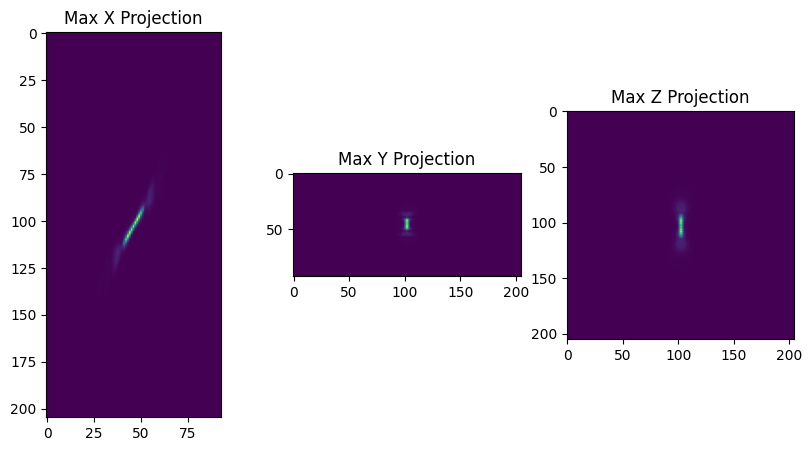

In [1]:
import numpy as np
import math 
from skimage.io import imread
import pyclesperanto_prototype as cle 
import numpy as np
import math 
from pycudadecon import RLContext,TemporaryOTF,rl_decon
from aicsimageio import AICSImage
from skimage.io import imread

psf = imread("../sample_data/psfs/zeiss_simulated/488.tif")

dzpsf=0.3
dxpsf=0.1449922

#Define a function for generating montages of the projection in different axes
def plot_montage_projections(img):
     
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,3, figsize=(10,5))

    ax[0].imshow(cle.maximum_x_projection(img))
    ax[0].set_title("Max X Projection")
    ax[1].imshow(cle.maximum_y_projection(img))
    ax[1].set_title("Max Y Projection")
    ax[2].imshow(cle.maximum_z_projection(img))
    ax[2].set_title("Max Z Projection")
    return

#Montage of PSF image
print("Image of simulated PSF from Zeiss lattice light sheet microscope. The image is skewed, hence why the bead appears blurry")
plot_montage_projections(psf)

#function to crop the PSF image
def crop_psf(psf_img:np.ndarray,perc_max_threshold:float=3e-3):
    psf_max = psf_img.max()
    psf_threshold = psf_max * perc_max_threshold
    #print(psf_threshold)
    psf_filtered = psf_img>psf_threshold
    #Get dimensions for min and max, where psf is greater than threshold
    min_z,min_y,min_x = np.min(np.where(psf_filtered),axis = 1)
    max_z,max_y,max_x = np.max(np.where(psf_filtered),axis = 1)
    psf_crop = psf_img[min_z:max_z,min_y:max_y,min_x:max_x]
    return psf_crop

(93, 205, 205)
(93, 205, 205)


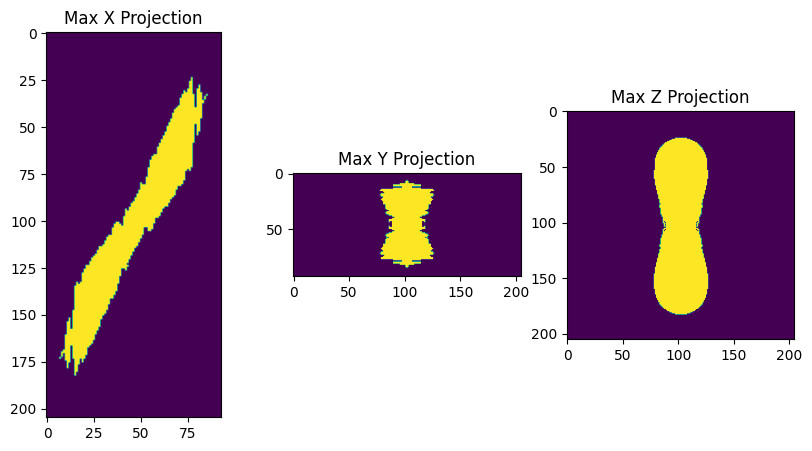

In [2]:
#Using % of 3e-4 and plotting how filtered psf will look like
psf_max = psf.max()
psf_threshold = psf_max * 3e-4
psf_filtered = psf>psf_threshold
plot_montage_projections(psf_filtered)
print(psf.shape)
print(psf_filtered.shape)

(93, 205, 205)
(78, 158, 48)


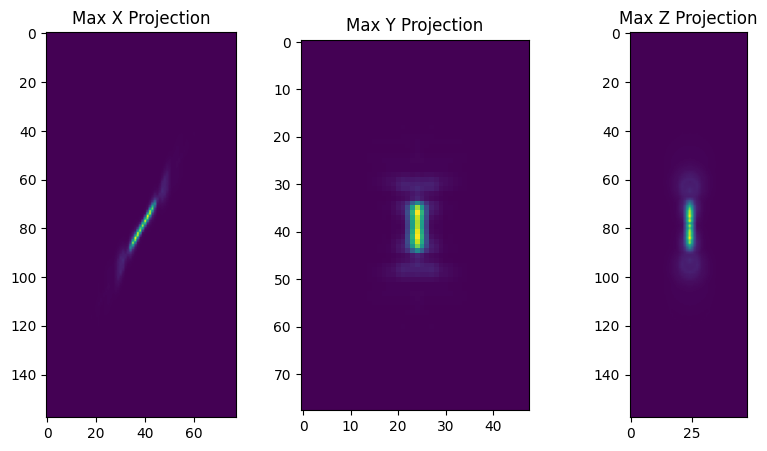

In [3]:
psf_cropped = crop_psf(psf,perc_max_threshold=3e-4)
plot_montage_projections(psf_cropped)
print(psf.shape)
print(psf_cropped.shape)

In [4]:
#Read small lattice light sheet image
image = AICSImage("../sample_data/RBC_tiny.czi")
image = np.squeeze(image.data)
print(image.shape)
dzdata=0.3
dxdata=0.1449922
dzpsf=0.3
dxpsf=0.1449922

(834, 118, 209)


In [5]:
#no cropping
with TemporaryOTF(psf) as otf:
    with RLContext(rawdata_shape=image.shape, otfpath=otf.path, dzdata=dzdata, dxdata=dxdata,dzpsf=dzpsf,dxpsf=dxpsf) as ctx:
        decon_res_no_crop = rl_decon(im=image, output_shape = ctx.out_shape,n_iters=10)

print(f"NO cropping; Image shape is {image.shape}. Decon image shape is {decon_res_no_crop.shape}")

#with cropping
with TemporaryOTF(psf_cropped) as otf:
    with RLContext(rawdata_shape=image.shape, otfpath=otf.path, dzdata=dzdata, dxdata=dxdata,dzpsf=dzpsf,dxpsf=dxpsf) as ctx:
        decon_res_crop = rl_decon(im=image, output_shape = ctx.out_shape,n_iters=10)

print(f"WITH cropping; Image shape is {image.shape}. Decon image shape is {decon_res_no_crop.shape}")


NO cropping; Image shape is (834, 118, 209). Decon image shape is (810, 112, 200)
WITH cropping; Image shape is (834, 118, 209). Decon image shape is (810, 112, 200)


Pycudadecon: The edges of the deconvolved image with cropped psf is not as sharp as the uncropped psf


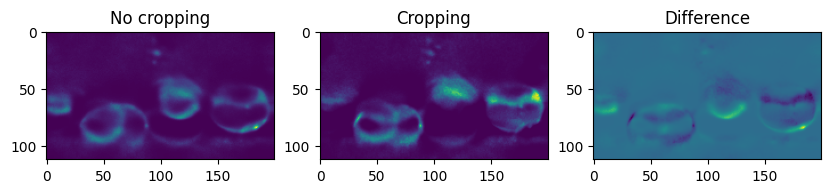

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(10,5))
ax[0].imshow(decon_res_no_crop[0])
ax[0].set_title("No cropping")
ax[1].imshow(decon_res_crop[0]) 
ax[1].set_title("Cropping")
ax[2].imshow(decon_res_no_crop[0]-decon_res_crop[0])   
ax[2].set_title("Difference")
print("Pycudadecon: The edges of the deconvolved image with cropped psf is not as sharp as the uncropped psf")

REDLIONFISH - OpenCL-based deconvolution

In [7]:
import RedLionfishDeconv as rl
#no cropping
img_decon_large_no_crop= rl.doRLDeconvolutionFromNpArrays(data_np = image, 
                                                    psf_np = psf, 
                                                    niter= 10, 
                                                    method = "gpu")

img_decon_large_crop= rl.doRLDeconvolutionFromNpArrays(data_np = image, 
                                                    psf_np = psf_cropped, 
                                                    niter= 10, 
                                                    method = "gpu")

RedLionFIsh: There is still a loss of sharpness in the edges with cropped PSF, but not as much as pycudadecon


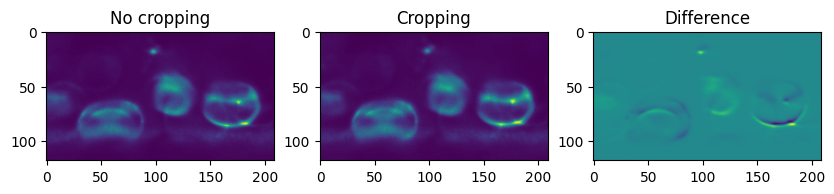

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(10,5))
ax[0].imshow(img_decon_large_no_crop[0])
ax[0].set_title("No cropping")
ax[1].imshow(img_decon_large_crop[0]) 
ax[1].set_title("Cropping")
ax[2].imshow(img_decon_large_no_crop[0]-img_decon_large_crop[0])   
ax[2].set_title("Difference")
print("RedLionFIsh: There is still a loss of sharpness in the edges with cropped PSF, but not as much as pycudadecon")

In [9]:
def pad_image_nearest_multiple(img:np.ndarray,nearest_multiple:int):
    """pad an Image to the nearest multiple of provided number

    Args:
        img (np.ndarray): 
        nearest_multiple (int): Multiple of number to be padded

    Returns:
        np.ndarray: Padded image
    """    
    rounded_shape = tuple([math.ceil(dim/nearest_multiple)*nearest_multiple for dim in img.shape])
    #get required padding
    padding = np.array(rounded_shape) - np.array(img.shape)
    padded_img = np.pad(img,((0,padding[0]),(0,padding[1]),(0,padding[2])),mode="reflect")
    return padded_img

psf_crop_pad = pad_image_nearest_multiple(psf_cropped,16)
print(psf_cropped.shape)
print(psf_crop_pad.shape)


#pad image y dimensions that are multiple of 64 and also pad by half of shape
z_psf_pad,y_psf_pad,x_psf_pad = np.array(psf_crop_pad.shape) //2

orig_shape = image.shape
image_padded = np.pad(image,((z_psf_pad,z_psf_pad),(y_psf_pad,y_psf_pad),(x_psf_pad,x_psf_pad)),mode="reflect")
image_padded = pad_image_nearest_multiple(image_padded,64)
print(f"Image shape is {orig_shape}. Padded image shape is {image_padded.shape}")

(78, 158, 48)
(80, 160, 48)
Image shape is (834, 118, 209). Padded image shape is (960, 320, 320)


In [10]:
#USE PADDED IMAGE and padded PSF
with TemporaryOTF(psf_crop_pad) as otf:
    with RLContext(rawdata_shape=image_padded.shape, otfpath=otf.path, dzdata=dzdata, dxdata=dxdata,dzpsf=dzpsf,dxpsf=dxpsf) as ctx:
        decon_res_crop = rl_decon(im=image_padded, output_shape = ctx.out_shape,n_iters=10)

print(f"Image shape is {image_padded.shape}. Decon image shape is {decon_res_crop.shape}")


Image shape is (960, 320, 320). Decon image shape is (960, 320, 320)


Padding image and PSF ensures there is no alteration of shape with deconvolved image. Now, lets test this with a larger dataset

In [11]:
img_large = AICSImage("E:\Python_Repos\RBC_full_time_series.czi")
img_large_data = img_large.data[0,0,...]
print(img_large_data.shape)

(834, 300, 2048)


Using cropped PSF and RedFishLion library

In [12]:
img_decon_large_cropped= rl.doRLDeconvolutionFromNpArrays(data_np = img_large_data, 
                                                    psf_np = psf_cropped, 
                                                    niter= 10, 
                                                    method = "gpu")
print(f"Image shape is {img_large_data.shape}. Padded image shape is {img_decon_large_cropped.shape}")

15-Nov-22 21:32:08 - root     - WARNING  - Adjusted blockshape is larger than GPU data size limits. Error may occur


Image shape is (834, 300, 2048). Padded image shape is (834, 300, 2048)


Text(0.5, 1.0, 'Decon')

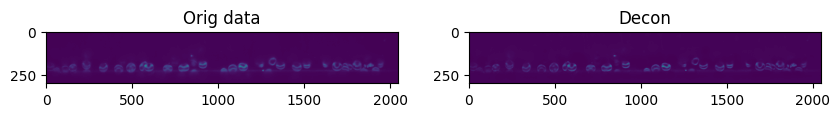

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(img_large_data[5])
ax[0].set_title("Orig data")
ax[1].imshow(img_decon_large_cropped[5]) 
ax[1].set_title("Decon")
#ax[2].imshow(img_decon_large_no_crop[0]-img_decon_large_crop[0])   
#ax[2].set_title("Difference")

In [19]:
image = img_large_data
#pad image y dimensions that are multiple of 64 and also pad by half of shape
z_psf_pad,y_psf_pad,x_psf_pad = np.array(psf.shape) //2

orig_img_shape = img_large_data.shape
#image_padded = np.pad(img_large_data,((z_psf_pad,z_psf_pad),(y_psf_pad,y_psf_pad),(x_psf_pad,x_psf_pad)),mode="reflect")
image_padded = pad_image_nearest_multiple(image,32)
print(image_padded.shape)

with TemporaryOTF(psf) as otf:
    with RLContext(rawdata_shape=image_padded.shape, otfpath=otf.path, dzdata=dzdata, dxdata=dxdata,dzpsf=dzpsf,dxpsf=dxpsf) as ctx:
        decon_res = rl_decon(im=image_padded, output_shape = ctx.out_shape,n_iters=10)

print(f"Decon: Image shape is {image_padded.shape}. Decon image shape is {decon_res.shape}")
shape_diff = np.array(decon_res.shape) - np.array(orig_img_shape)
#if above is negative, 
if shape_diff[0]==0:
    shape_diff[0] = -orig_img_shape[0]
if shape_diff[1]==0:
    shape_diff[1] = -orig_img_shape[1]
if shape_diff[2]==0:
    shape_diff[2] = -orig_img_shape[2]
decon_res = decon_res[:-shape_diff[0],:-shape_diff[1],:-shape_diff[2]]
print(decon_res.shape)

(864, 320, 2048)


OSError: [WinError -529697949] Windows Error 0xe06d7363

In [ ]:
import napari
viewer = napari.Viewer()
viewer.add_image(img_large_data)
viewer.add_image(img_decon_large_cropped)
viewer.add_image(decon_res)

c:\Users\Pradeep\.conda\envs\napari_lattice\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'decon_res' at 0x1a0acec49d0>

24 60 90
68 146 114
[44 86 24]
(44, 86, 24)


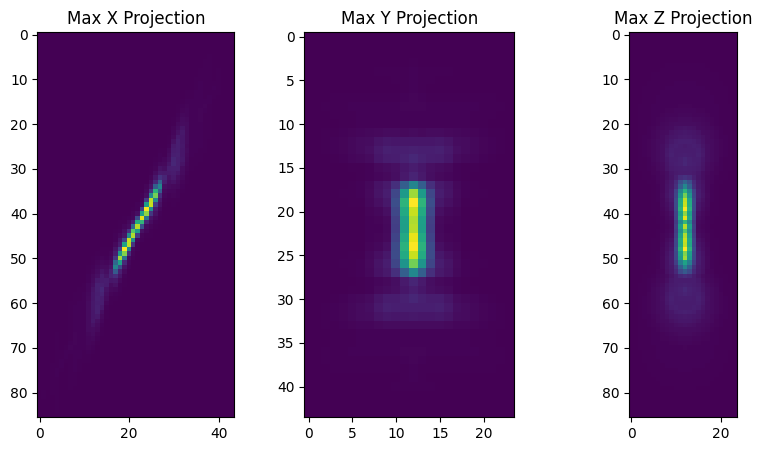

In [ ]:
min_z,min_y,min_x = np.min(np.where(psf_filtered),axis = 1)
max_z,max_y,max_x = np.max(np.where(psf_filtered),axis = 1)


print(min_z,min_y,min_x)
print(max_z,max_y,max_x)

psf_shape = np.max(np.where(psf_filtered),axis = 1) - np.min(np.where(psf_filtered),axis = 1)
print(psf_shape)

psf_crop = psf[min_z:max_z,min_y:max_y,min_x:max_x]
print(psf_crop.shape)
plot_montage_projections(psf_crop)

In [ ]:
#Can also Use RedLionfish library to crop PSF, once you know the shape for cropping
from RedLionfishDeconv.helperfunctions import change3DSizeTo
psf_crop_RL = change3DSizeTo(psf,psf_crop.shape)

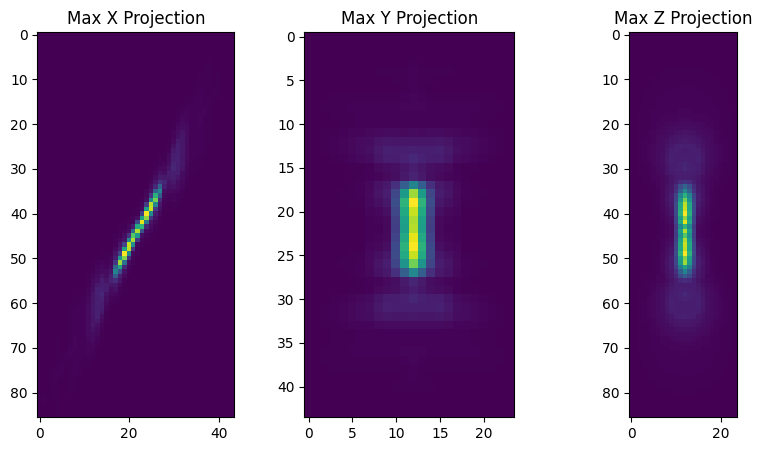

In [ ]:
plot_montage_projections(psf_crop_RL)